In [3]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt

def bias(x, a):
  return x/(((1/a-2)*(1-x))+1)

def gain(x, a):
  return np.where(x < 0.5, bias(2*x, a)/2, (bias(2*x-1,1-a)+1)/2)

def curve(x, s, t):
  assert s >= 0
  assert t >= 0 and t <= 1
  assert np.all((x >= 0) & (x <= 1))
  eps = np.finfo(float).eps
  z = np.where(x < t, (t*x)/(x+s*(t-x)+eps), ((1-t)*(x-1))/(1-x-s*(t-x)+eps)+1)
  return z

curve_grad = lambda x, s, t: jax.grad(lambda x, s, t : np.sum(curve(x, s, t)), [0])(x, s, t)[0]

In [4]:
x = np.linspace(0, 1, 10000)

tol = 1e-4

# We can reproduce Schlick gain.
for s in 2**np.linspace(-10, 10, 21)[1:-1]:
  y0 = gain(x, 1/(s+1))
  y1 = curve(x, s, 0.5)
  assert np.max(np.abs(y0 - y1)) < tol

# We can reproduce Schlick bias two different ways.
for s in 2**np.linspace(-10, 10, 21)[1:-1]:
  y0 = bias(x, 1/(s+1))
  y1 = curve(x, s, 1.)
  y2 = curve(x, 1/s, 0.)
  assert np.max(np.abs(y0 - y1)) < tol
  assert np.max(np.abs(y0 - y2)) < tol

# It's its own inverse. 
for t in np.linspace(0, 1, 5):
  for s in 2**np.linspace(-10, 10, 21)[1:-1]:
    xr = curve(curve(x, s, t), 1/s, t)
    assert np.max(np.abs(x - xr)) < tol

# It's symmetric in some nice ways.
for t in np.linspace(0, 1, 5):
  for s in 2**np.linspace(-10, 10, 21)[1:-1]:
    y0 = curve(x, s, t)
    y1 = 1-curve(1-x, s, 1-t)
    assert np.max(np.abs(y0 - y1)) < tol

# It always maps t to t, 0 to 0, and 1 to 1
for t in np.linspace(0, 1, 5):
  for s in 2**np.linspace(-10, 10, 21)[1:-1]:
    assert np.abs(curve(t, s, t) - t) < tol
    assert np.abs(curve(0, s, t) - 0) < tol
    assert np.abs(curve(1, s, t) - 1) < tol

# The gradient at x=t is s
for t in np.linspace(0, 1, 5)[1:-1]:
  for s in 2**np.linspace(-10, 10, 21)[1:-1]:
    assert np.abs(s - curve_grad(t, s, t)) < tol

/Users/jon/opt/miniconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


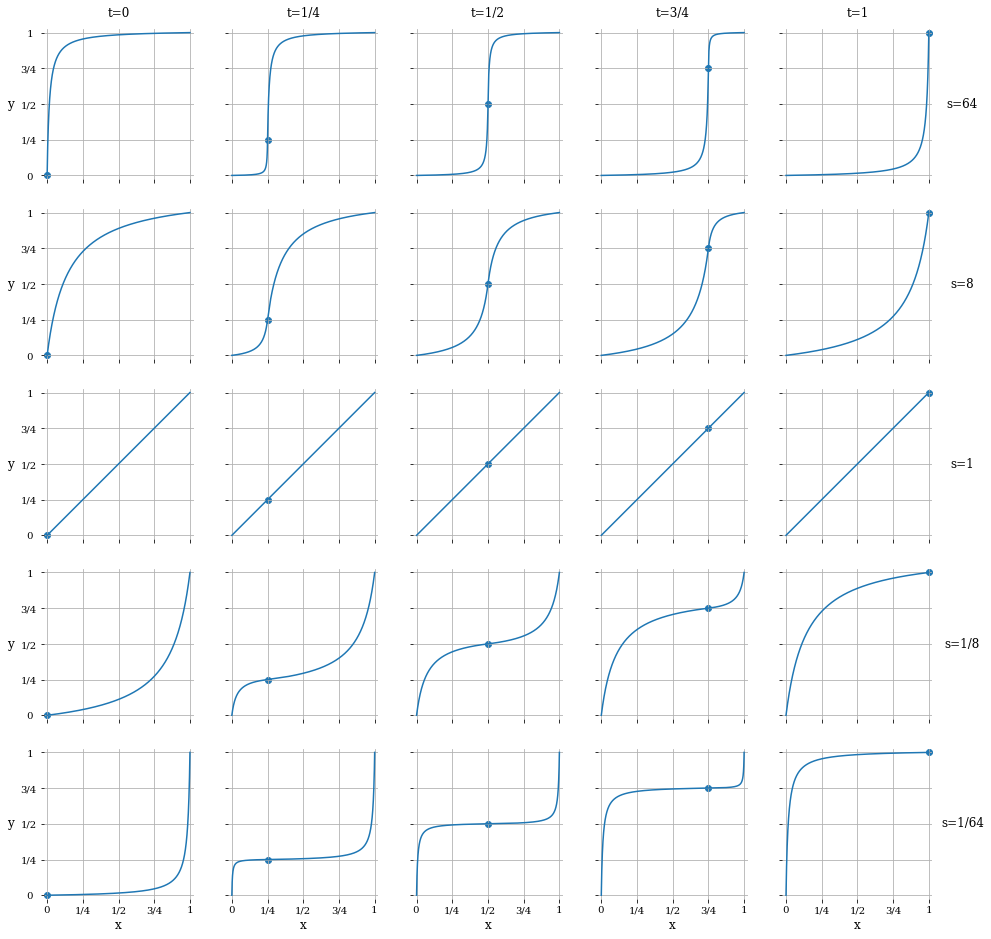

In [5]:
plt.rc('font', family='serif')

x = np.linspace(0, 1, 10000)
ss = [64, 8, 1 , 1/8, 1/64]
ts = [0, 0.25, 0.5, 0.75, 1]
plt.figure(figsize=(16,16))
for si, s in enumerate(ss):
  for ti, t in enumerate(ts):
    plt.subplot(len(ss), len(ts), ti + si * len(ts)+1)
    y = curve(x, s, t)
    assert np.sum(np.isnan(y)) == 0
    plt.plot(x, y, label=f'{s} {t}')
    plt.scatter(t, t)
    plt.grid(True)
    plt.axis('square');
    plt.gca().set_xticks(ts)
    plt.gca().set_yticks(ts)
    if si == 4:
      plt.gca().set_xticklabels([' 0 ', '1/4', '1/2', '3/4', ' 1 '])
      plt.gca().set_xlabel('x', FontSize=12)
    else:
      plt.gca().set_xticklabels([])
      if si == 0:
        t_str = ['0', '1/4', '1/2', '3/4', '1'][ti]
        plt.gca().set_xlabel(f't={t_str}', FontSize=12, rotation=0)
        plt.gca().xaxis.set_label_coords(0.5,1.15)
    if ti == 0:
      plt.gca().set_yticklabels([' 0 ', '1/4', '1/2', '3/4', ' 1 '])
      plt.gca().set_ylabel('y', FontSize=12, rotation=0)
      plt.gca().yaxis.set_label_coords(-0.22,0.46)
    else:
      plt.gca().set_yticklabels([])
      if ti == 4:
        if s >= 1:
          plt.gca().set_ylabel(f's={s}', FontSize=12, rotation=0)
        else:
          plt.gca().set_ylabel(f's=1/{int(1/s)}', FontSize=12, rotation=0)
      plt.gca().yaxis.set_label_coords(1.2,0.46)
    plt.gca().set_xlim(-0.025, 1.025)
    plt.gca().set_ylim(-0.025, 1.025)
    plt.box(False)